In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import data_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[2:5,:])
# task_colors = np.flipud(cm.GnBu(np.linspace(0,1,6))[2:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
# the original decoding analysis includes a fourth task (one-back or repeat detection)
# but we aren't going to look at those results here
tasks_use = np.array([0,1,2])

In [4]:
task_colors

array([[0.03137255, 0.25098039, 0.50588235, 1.        ],
       [0.16539792, 0.54569781, 0.74343714, 1.        ],
       [0.47958478, 0.79846213, 0.76955017, 1.        ]])

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')

print(save_filename)

dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy


dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'acc_each_cval', 'best_cval', 'grid_pts', 'roi_names'])

In [8]:
np.nanmedian(dec_withintask['best_cval'].ravel())

0.023357214690901212

In [9]:
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask_permutationtest.npy')

print(save_filename)

dec_withintask_shuff = np.load(save_filename, allow_pickle=True).item()

n_iter = dec_withintask_shuff['acc_bytask'].shape[3]

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_permutationtest.npy


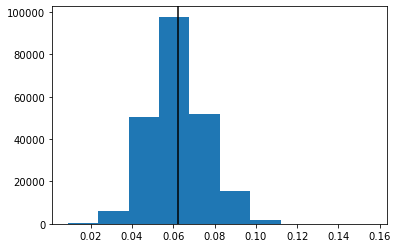

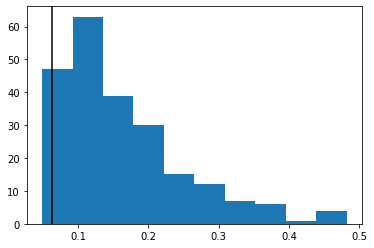

In [10]:
# double checking the permuted values
plt.figure()
shuffvals = dec_withintask_shuff['acc_bytask']
plt.hist(shuffvals.ravel())
plt.axvline(1/16, color='k')

# and real values
plt.figure()
realvals = dec_withintask['acc_bytask']
plt.hist(realvals.ravel())
plt.axvline(1/16, color='k')


In [11]:
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### compute p-values for decoding accuracy.

In [12]:
# first for single subjects
p_onetailed_ss = np.mean(dec_withintask_shuff['acc_bytask'] >= \
                           np.tile(dec_withintask['acc_bytask'][:,:,:,None], [1,1,1,n_iter]), \
                          axis=3)
p_onetailed_ss = p_onetailed_ss[:,:,tasks_use]

# fdr correction
_, p_onetailed_ss_fdr = stats_utils.fdr_keepshape(p_onetailed_ss, alpha=0.01, \
                                                       method='poscorr')
# count how many subjects were significant individually
n_subs_sig = np.sum(p_onetailed_ss_fdr<0.01, axis=0)

# then for the subject-averaged accuracy values
# average within iterations first, then compute p-value
sub_avg_shuff = np.mean(dec_withintask_shuff['acc_bytask'], axis=0)
sub_avg_real = np.mean(dec_withintask['acc_bytask'], axis=0)

p_onetailed_subavg = np.mean(sub_avg_shuff >= \
                         np.tile(sub_avg_real[:,:,None], [1,1,n_iter]), \
                          axis=2)
p_onetailed_subavg = p_onetailed_subavg[:,tasks_use]

# fdr correction
_, p_onetailed_subavg_fdr = stats_utils.fdr_keepshape(p_onetailed_subavg, alpha=0.01, \
                                                       method='poscorr')

#### make a table of significance tests

In [13]:
d = pd.DataFrame([], index=roi_names)

for ti in tasks_use:
    
    vals = dec_withintask['acc_bytask'][:,:,ti]
    meanvals = np.mean(vals, axis=0)
    
    d['%s: mean acc'%(task_names[ti])] = meanvals
    d['%s: p-value'%(task_names[ti])] = p_onetailed_subavg_fdr[:,ti]
    d['%s: n subs sig'%(task_names[ti])] = n_subs_sig[:,ti]
    

d

,Linear (1): mean acc,Linear (1): p-value,Linear (1): n subs sig,Linear (2): mean acc,Linear (2): p-value,Linear (2): n subs sig,Checker: mean acc,Checker: p-value,Checker: n subs sig
V1,0.247619,0.0,7,0.260789,0.0,7,0.228186,0.0,7
V2,0.279167,0.0,7,0.300595,0.0,7,0.252367,0.0,7
V3,0.229241,0.0,7,0.225074,0.0,7,0.209821,0.0,7
V3AB,0.148363,0.0,6,0.145461,0.0,7,0.126319,0.0,6
hV4,0.103423,0.0,5,0.103795,0.0,4,0.096253,0.0,4
LO1,0.111905,0.0,5,0.127232,0.0,5,0.119859,0.0,6
LO2,0.097247,0.0,4,0.096354,0.0,4,0.086580,0.0,1
IPS,0.096652,0.0,3,0.084449,0.0,2,0.098620,0.0,1


In [14]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

#### Overall accuracy of the 16-way classifier

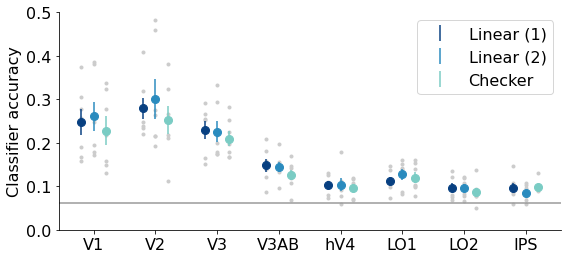

In [15]:
ti_plot = tasks_use

x_jitter = np.linspace(-0.2, 0.2, 3)

plt.figure(figsize=(9,4))

ax = plt.subplot(1,1,1)

plt.axhline(1/16, color=[0.6, 0.6, 0.6])

lh = []

for ti in ti_plot:

    x_ticks = np.arange(n_rois) + x_jitter[ti]

    vals = dec_withintask['acc_bytask'][:,:,ti]
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], \
                     linestyle='none', zorder=10)
    lh.append(h)

    plt.plot(x_ticks, vals.T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
    
plt.ylim([0, 0.5])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('Classifier accuracy')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(lh,np.array(task_names)[ti_plot])

# plt.title('16-way logistic regression classifier, overall acc')

figname = os.path.join(figfolder, 'multinomial_avg_categtasks.pdf')
plt.savefig(figname)

In [16]:
vals = dec_withintask['acc_bytask'][:,:,tasks_use]
vals = np.mean(vals, axis=2)
mvals = np.mean(vals, axis=0)
svals = np.std(vals, axis=0)/np.sqrt(n_subjects)

pd.DataFrame({'mean acc': mvals, \
              'sem acc': svals, }, \
             index=roi_names).round(2)


,mean acc,sem acc
V1,0.25,0.03
V2,0.28,0.03
V3,0.22,0.02
V3AB,0.14,0.01
hV4,0.10,0.01
LO1,0.12,0.01
LO2,0.09,0.01
IPS,0.09,0.00


In [17]:
vals = dec_withintask['acc_bytask'][:,:,tasks_use]

stats_utils.rmanova_2way(vals,['ROI','task'], do_shuffle=True, n_iter=10000, rndseed=968878)

,F Value,Num DF,Den DF,Pr > F,p (permutation)
ROI,27.379472,7.0,42.0,1.033294e-13,0.0000
task,1.328355,2.0,12.0,3.012093e-01,0.3077
ROI:task,2.007644,14.0,84.0,2.657685e-02,0.0227
